# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.decomposition import TruncatedSVD

In [2]:
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
# Calculate the number of interactions per user
user_interactions = df['email'].value_counts()

# Descriptive statistics
median_val = user_interactions.median()
max_views_by_user = user_interactions.max()

print(f"50% of users interact with {median_val} articles or fewer.")
print(f"The maximum number of user-article interactions by any single user is {max_views_by_user}.")



50% of users interact with 3.0 articles or fewer.
The maximum number of user-article interactions by any single user is 364.


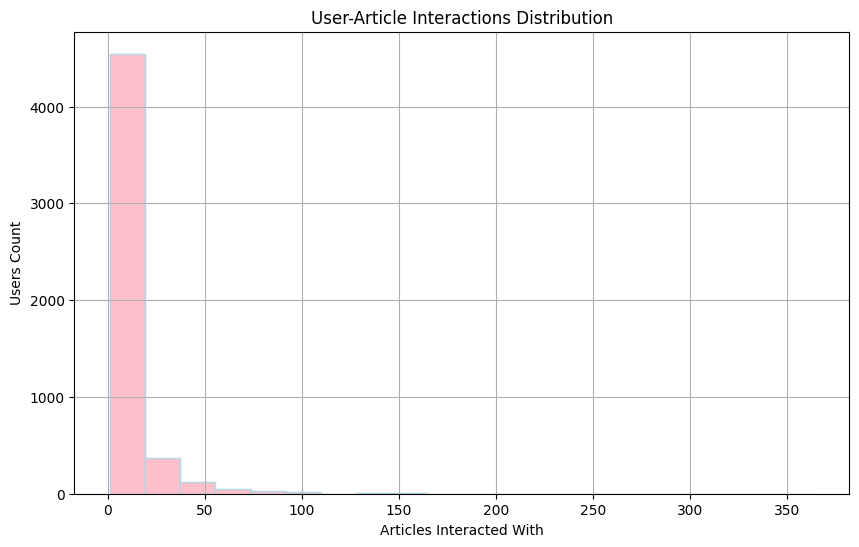

In [9]:
# Plotting the distribution of user-article interactions
plt.figure(figsize=(10, 6))
plt.hist(user_interactions, bins=20, color='pink', edgecolor='lightblue')
plt.title('User-Article Interactions Distribution')
plt.xlabel('Articles Interacted With')
plt.ylabel('Users Count')
plt.grid(True)
plt.show()


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Identify and explore duplicate articles by 'article_id'
duplicate_articles = df_content[df_content['article_id'].duplicated()]

In [11]:
df_content[df_content['article_id']==50]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50


In [12]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')
df_content[df_content.duplicated(['article_id'])]


,doc_body,doc_description,doc_full_name,doc_status,article_id


`3.` In this part, we investigate these question's answers:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [14]:

unique_counts = df[df['article_id'].isin(df_content['article_id'].unique())].nunique()
unique_counts

article_id     437
title          437
email         4257
dtype: int64

In [15]:
df_content['article_id'].nunique()


1051

In [16]:
df['article_id'].nunique()

714

In [18]:
unique_articles = 714  # The count of distinct articles that have been interacted with at least once
total_articles = 1051  # The total number of distinct articles available on the IBM platform
unique_users = 5148  # The count of distinct users who have interacted with articles
user_article_interactions = 45993  # The total number of interactions between users and articles


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [19]:
# Convert article_id to a string type
df['article_id'] = df['article_id'].astype(str)

# Calculate the number of interactions for each article_id
article_view_counts = df['article_id'].value_counts().reset_index()
article_view_counts.columns = ['article_id', 'view_count']

# Identify the article_id with the highest view_count
most_viewed_article = article_view_counts.iloc[article_view_counts['view_count'].idxmax()]
print(most_viewed_article)


article_id    1429.0
view_count       937
Name: 0, dtype: object


In [20]:
# Function to map user emails to user_id and remove email column
def map_email_to_user_id():
    email_to_id = {}
    user_id_list = []
    current_id = 1
    
    for email in df['email']:
        if email not in email_to_id:
            email_to_id[email] = current_id
            current_id += 1
        
        user_id_list.append(email_to_id[email])
    
    return user_id_list

# Apply the mapping function
df['user_id'] = map_email_to_user_id()

# Drop the email column
df.drop(columns=['email'], inplace=True)

# Display the first few rows of the DataFrame
df.head()


,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>



`1.` Function below to return the **n** top articles ordered with most interactions as the top. 

In [21]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) Number of top articles to return
    df - (pandas DataFrame) DataFrame containing user-article interactions and article titles
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles
    
    '''
    # Count the number of interactions for each article
    article_view_counts = df['article_id'].value_counts().reset_index()
    article_view_counts.columns = ['article_id', 'view_count']
    
    # Sort the articles by interaction count in descending order and select the top n
    top_articles_df = article_view_counts.nlargest(n, 'view_count')
    
    # Merge with the original DataFrame to retrieve the article titles
    top_articles_with_titles = top_articles_df.merge(df[['article_id', 'title']], on='article_id').drop_duplicates('article_id')
    
    # Create a list of the top article titles
    top_articles = top_articles_with_titles['title'].tolist()
    
    return top_articles


In [22]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df containing user-article interactions
    
    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article ids 
    
    '''
    # Aggregate interactions by article_id
    article_view_counts = df.groupby('article_id').size().reset_index(name='view_count')
    
    # Sort articles by view_count in descending order and select the top n
    top_articles_df = article_view_counts.sort_values(by='view_count', ascending=False).head(n)
    
    # Extract the top article ids
    top_article_ids = top_articles_df['article_id'].tolist()
    
    return top_article_ids


In [23]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` In this part, we build function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 



In [24]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas DataFrame with columns: article_id, title, user_id
    
    OUTPUT:
    user_item - user-item interaction matrix 
    
    Description:
    Creates and returns a matrix where rows represent user IDs and columns represent article IDs. The matrix contains 1 
    for interactions between a user and an article, and 0 otherwise.
    '''
    # Create the user-item matrix by pivoting the DataFrame
    user_item = df.pivot_table(index='user_id', columns='article_id', values='title', aggfunc=lambda x: 1, fill_value=0)
    
    return user_item  # Return the user-item interaction matrix

# Generate the user-item matrix
user_item = create_user_item_matrix(df)
user_item


article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas DataFrame) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the most similar users (highest dot product) 
                    are listed first
    
    Description:
    Calculates the similarity of all users to the specified user based on the dot product of their interaction vectors.
    Returns a list of user IDs ordered by similarity.
    '''
    # Extract the interaction vector for the specified user
    user_vector = user_item.loc[user_id].values
    
    # Exclude the specified user and compute the dot product with all other users
    other_users = user_item.drop(user_id)
    similarities = other_users.dot(user_vector)
    
    # Convert the similarities into a DataFrame
    similarity_df = pd.DataFrame({
        'user_id': other_users.index,
        'similarity': similarities
    })
    
    # Sort the DataFrame by similarity in descending order
    similarity_df = similarity_df.sort_values(by='similarity', ascending=False)
    
    # Create a list of user IDs sorted by similarity
    similar_users = similarity_df['user_id'].tolist()
    
    return similar_users  # Return the list of similar users


In [26]:
# example usage
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [27]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article IDs
    df - (pandas DataFrame) DataFrame containing article data, including article_id and title columns
    
    OUTPUT:
    article_names - (list) a list of article names corresponding to the provided article IDs
                    (extracted from the title column)
    '''
    # Filter the DataFrame to include only the rows with the specified article_ids
    filtered_df = df[df['article_id'].isin(article_ids)]
    
    # Extract the unique article titles corresponding to the article_ids
    article_names = filtered_df['title'].unique().tolist()
    
    return article_names

# Example usage
get_article_names(['1430.0', '1170.0'])


['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'apache spark lab, part 1: basic concepts']

In [28]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''

    user_row = user_item.loc[user_id]
    
    # Get the article_ids where the user has interacted (i.e., where the value is 1)
    article_ids = user_row[user_row == 1].index.get_level_values('article_id').tolist()

    
    # Use the get_article_names function to get the article names
    article_names = get_article_names(article_ids)
  
    
    return article_ids, article_names

# ex. usage
get_user_articles(1)

(['1052.0',
  '109.0',
  '1170.0',
  '1183.0',
  '1185.0',
  '1232.0',
  '1293.0',
  '1305.0',
  '1363.0',
  '1368.0',
  '1391.0',
  '1400.0',
  '1406.0',
  '1427.0',
  '1429.0',
  '1430.0',
  '1431.0',
  '1436.0',
  '1439.0',
  '151.0',
  '268.0',
  '310.0',
  '329.0',
  '346.0',
  '390.0',
  '43.0',
  '494.0',
  '525.0',
  '585.0',
  '626.0',
  '668.0',
  '732.0',
  '768.0',
  '910.0',
  '968.0',
  '981.0'],
 ['using pixiedust for fast, flexible, and easier data analysis and experimentation',
  'use deep learning for image classification',
  'classify tumors with machine learning',
  'apache spark lab, part 1: basic concepts',
  'access db2 warehouse on cloud and db2 with python',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'putting a human face on machine learning',
  'gosales transactions for naive bayes model',
  'welcome to pixiedust',
  'uci ml repository: chronic kidney disease data set',
  'time series prediction usin

In [29]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id.
    For each user, finds articles the user hasn't seen before and provides them as recommendations.
    Continues this process until m recommendations are found.
    
    Notes:
    Users with the same closeness are chosen arbitrarily as the 'next' user.
    If the number of recommended articles starts below m and exceeds m, the last items are chosen arbitrarily.
    '''
    similar_users = find_similar_users(user_id, user_item)
    seen_article_ids, _ = get_user_articles(user_id)
    recs = []

    for similar_user in similar_users:
        if len(recs) >= m:
            break
        similar_user_article_ids, _ = get_user_articles(similar_user)
        new_recs = [article for article in similar_user_article_ids if article not in seen_article_ids]
        recs.extend(new_recs)
        recs = list(dict.fromkeys(recs))  # Remove duplicates
        if len(recs) > m:
            recs = recs[:m]

    return recs


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [30]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) ID of the user for whom we want to find similar users
    df - (pandas DataFrame) DataFrame containing user-article interactions
    user_item - (pandas DataFrame) matrix of users by articles, where 1 indicates interaction and 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas DataFrame) DataFrame containing:
                    neighbor_id - user ID of the neighbor
                    similarity - similarity score of each neighbor compared to the input user_id
                    num_interactions - the number of articles viewed by the neighbor
    
    Description:
    The function calculates similarity between the input user and all other users based on their article interaction vectors.
    It then returns a DataFrame of similar users, sorted first by similarity and then by the number of interactions.
    '''
    # Calculate similarity as the dot product between the user's interaction vector and all other users' interaction vectors
    user_vector = user_item.loc[user_id].values
    similarity = user_item.dot(user_vector)
    
    # Create a DataFrame containing neighbor_id, similarity, and num_interactions
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarity.index,
        'similarity': similarity.values,
        'num_interactions': user_item.sum(axis=1)
    })
    
    # Remove the input user_id from the neighbors_df
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # Sort the DataFrame first by similarity, then by num_interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False])
    
    # Reset the index and ensure neighbor_id is a string
    neighbors_df = neighbors_df.reset_index(drop=True)
    neighbors_df['neighbor_id'] = neighbors_df['neighbor_id'].astype(str)
    
    return neighbors_df  # Return the sorted DataFrame

# Example usage
get_top_sorted_users(1)


,neighbor_id,similarity,num_interactions
0,3933,35,35
1,23,17,135
2,3782,17,135
3,203,15,96
4,4459,15,96
...,...,...,...
5143,5141,0,1
5144,5144,0,1
5145,5147,0,1
5146,5148,0,1


In [55]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id.
    For each user, finds articles the user hasn't seen before and provides them as recommendations.
    Does this until m recommendations are found.
    
    Notes:
    * Choose the users that have the most total article interactions before choosing those with fewer.
    * Choose articles with the most total interactions before choosing those with fewer total interactions.
    '''
    # Step 1: Find similar users
    similar_users = find_similar_users(user_id, user_item)
    
    # Step 2: Get the articles the target user has already seen
    seen_article_ids, _ = get_user_articles(user_id)
    
    recs = []

    # Step 3: Loop through similar users to find new recommendations
    for similar_user in similar_users:
        if len(recs) >= m:
            break
        
        # Get articles seen by the similar user
        similar_user_article_ids, _ = get_user_articles(similar_user)
        
        # Find articles not seen by the target user
        new_recs = [article for article in similar_user_article_ids if article not in seen_article_ids]
        
        # Add these new recommendations to the recs list
        recs.extend(new_recs)
        
        # Remove duplicates
        recs = list(dict.fromkeys(recs))
        
        # Limit the number of recommendations to m
        if len(recs) > m:
            recs = recs[:m]

    # Step 4: Get the article titles corresponding to the recommended article IDs
    rec_names = get_article_names(recs)

    return recs, rec_names

# Example usage
user_user_recs_part2(1)


(['1000.0',
  '1014.0',
  '1025.0',
  '1051.0',
  '108.0',
  '1101.0',
  '1148.0',
  '1159.0',
  '1160.0',
  '1162.0'],
 ['analyze energy consumption in buildings',
  'analyze accident reports on amazon emr spark',
  '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
  '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
  'data tidying in data science experience',
  'airbnb data for analytics: vancouver listings',
  'recommender systems: approaches & algorithms',
  'airbnb data for analytics: mallorca reviews',
  'analyze facebook data using ibm watson and watson studio',
  'a tensorflow regression model to predict house values'])

In [56]:
user1_most_sim = int(get_top_sorted_users(1).iloc[0]['neighbor_id']) # Find the user that is most similar to user 1 
user131_10th_sim = int(get_top_sorted_users(131).iloc[10]['neighbor_id']) # Find the 10th most similar user to user 131

For new users, we can use top article_ids sorted by their interaction counts

In [33]:
def get_top_articles(df, top_n=10):
    '''
    INPUT:
    df - (pandas DataFrame) the DataFrame containing user-article interactions
    top_n - (int) the number of top articles to return based on interaction counts
    
    OUTPUT:
    top_articles - (list) a list of the top article_ids sorted by the number of interactions
    
    Description:
    This function calculates the number of interactions each article has received, 
    then returns a list of the top `top_n` article IDs, sorted by interaction count in descending order.
    '''
    # Count the number of interactions for each article
    article_interaction_counts = df.groupby('article_id').size()
    
    # Sort articles by interaction count in descending order and select the top_n
    top_articles = article_interaction_counts.sort_values(ascending=False).head(top_n).index.tolist()
    
    return top_articles


In [34]:
new_user = '0.0'

new_user_recs = get_top_articles(df, top_n=10)



### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [35]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [36]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Performing SVD

In [37]:
# Perform SVD on the User-Item Matrix 
u, s, vt = np.linalg.svd(user_item_matrix)

How do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

c:\Users\feyza.cotuk\AppData\Local\anaconda3\envs\ava\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


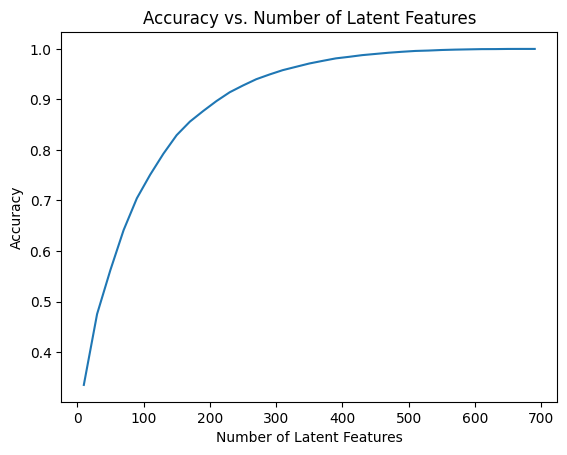

In [38]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [40]:
df_train = df.head(40000)
df_test = df.tail(5993)

df_train = df_train.drop_duplicates(subset=['user_id', 'article_id'])
df_test = df_test.drop_duplicates(subset=['user_id', 'article_id'])

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
     # Create the user-item matrix for the training set
    user_item_train = df_train.groupby(['user_id', 'article_id'])['title'].count().unstack().notnull().astype(int)
    
    # Create the user-item matrix for the test set
    user_item_test = df_test.groupby(['user_id', 'article_id'])['title'].count().unstack().notnull().astype(int)
    
    # Get the test user ids (index of the test user-item matrix)
    test_idx = user_item_test.index.tolist()
    
    # Get the test article ids (columns of the test user-item matrix)
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [41]:
def evaluate_predictions(user_item_train, user_item_test):
    '''
    INPUT:
    user_item_train - a user-item matrix of the training dataframe
    user_item_test - a user-item matrix of the testing dataframe
    
    OUTPUT:
    answers - a dictionary with the following keys and their corresponding counts:
              'number_of_users_in_test_with_predictions' - Number of users in test set with interactions in training set
              'number_of_users_in_test_no_predictions' - Number of users in test set without interactions in training set
              'number_of_articles_in_test_with_predictions' - Number of articles in test set with interactions in training set
              'number_of_articles_in_test_no_predictions' - Number of articles in test set without interactions in training set
    '''
    # Users in the test set
    test_users = user_item_test.index
    # Articles in the test set
    test_articles = user_item_test.columns
    
    # Users with interactions in the training set
    train_users = user_item_train.index
    # Articles with interactions in the training set
    train_articles = user_item_train.columns
    
    # Number of users in the test set with interactions in the training set
    users_with_predictions = test_users[test_users.isin(train_users)]
    number_of_users_with_predictions = len(users_with_predictions)
    
    # Number of users in the test set without interactions in the training set
    users_without_predictions = test_users[~test_users.isin(train_users)]
    number_of_users_without_predictions = len(users_without_predictions)
    
    # Number of articles in the test set with interactions in the training set
    articles_with_predictions = test_articles[test_articles.isin(train_articles)]
    number_of_articles_with_predictions = len(articles_with_predictions)
    
    # Number of articles in the test set without interactions in the training set
    articles_without_predictions = test_articles[~test_articles.isin(train_articles)]
    number_of_articles_without_predictions = len(articles_without_predictions)
    
    answers = {
        'number_of_users_in_test_with_predictions': number_of_users_with_predictions,
        'number_of_users_in_test_no_predictions': number_of_users_without_predictions,
        'number_of_articles_in_test_with_predictions': number_of_articles_with_predictions,
        'number_of_articles_in_test_no_predictions': number_of_articles_without_predictions
    }
    
    return answers

# Example usage:
answers = evaluate_predictions(user_item_train, user_item_test)
print(answers)


{'number_of_users_in_test_with_predictions': 20, 'number_of_users_in_test_no_predictions': 662, 'number_of_articles_in_test_with_predictions': 574, 'number_of_articles_in_test_no_predictions': 0}


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [45]:
from sklearn.decomposition import TruncatedSVD

# Fit SVD on the user_item_train matrix
def fit_svd(user_item_matrix, n_features):
    svd = TruncatedSVD(n_components=n_features)
    u_train = svd.fit_transform(user_item_matrix)
    s_train = svd.singular_values_
    vt_train = svd.components_
    return u_train, s_train, vt_train

# Example: Fit SVD with 10 latent features
n_features = 10
u_train, s_train, vt_train = fit_svd(user_item_train, n_features)
u_train, s_train, vt_train


(array([[ 2.38365915, -0.16255386, -0.67309369, ..., -0.74384522,
          0.7123811 ,  0.83143585],
        [ 0.58372335, -0.3647093 , -0.07903251, ...,  0.19231186,
         -0.02068873, -0.28316563],
        [ 2.78142673,  0.03116889,  0.38134273, ...,  0.62599502,
          1.12653577, -0.764349  ],
        ...,
        [ 0.3971059 , -0.34897413, -0.06309422, ..., -0.12130542,
         -0.20402915,  0.0918263 ],
        [ 0.13974971, -0.12235238, -0.05237473, ...,  0.0455985 ,
         -0.03887803,  0.06396236],
        [ 0.82966035,  0.14646985,  0.15364577, ..., -0.10322054,
          0.53119934, -0.45913663]]),
 array([51.50052116, 21.91423975, 20.14908871, 19.44116346, 18.82049503,
        18.35870748, 17.9123403 , 17.52163978, 17.29025032, 16.82118798]),
 array([[ 2.17234336e-03,  9.49542838e-04,  8.45889906e-03, ...,
          8.65606176e-03,  2.79768143e-02,  2.93090774e-04],
        [-2.02927520e-03, -1.73239345e-03, -1.13714499e-03, ...,
          1.86003133e-02, -5.77678

In [51]:
def predict_ratings(u_train, s_train, vt_train, user_item_test, user_item_train):
    # Reconstruct the user-item matrix
    user_item_pred = np.dot(np.dot(u_train, np.diag(s_train)), vt_train)
    
    # Create a DataFrame for the predictions
    user_item_pred_df = pd.DataFrame(user_item_pred, index=user_item_train.index, columns=user_item_train.columns)
    
    # Align the predictions with the test users and articles using reindex
    predictions = user_item_pred_df.reindex(index=user_item_test.index, columns=user_item_test.columns, fill_value=0)
    
    return predictions

# Example usage:
predictions = predict_ratings(u_train, s_train, vt_train, user_item_test, user_item_train)

# Example: Predict ratings for test data
predictions

article_id,0.0,100.0,1000.0,1006.0,1008.0,101.0,1014.0,1016.0,1017.0,1018.0,...,973.0,975.0,977.0,98.0,981.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.059686,0.029980,0.187878,0.157722,0.075014,0.857694,1.533251,0.836535,2.377748,0.677673,...,0.131246,1.028697,0.303023,1.798208,0.816983,0.256233,0.318883,0.271808,0.500568,0.000993
3024,0.070527,-0.011096,0.747609,1.204494,0.269847,3.734112,6.647398,5.398263,12.809255,2.523833,...,0.806114,5.538161,1.440134,9.593478,2.759195,1.605804,2.443943,1.951706,2.623160,0.083884
3093,-0.001521,-0.023481,0.194957,0.319009,0.079104,1.264468,2.266462,1.973898,4.510638,0.807575,...,0.301538,1.802867,0.385910,3.169942,0.658067,0.568163,0.808989,0.743286,0.698346,0.029588
3193,0.039462,0.037138,-0.000360,0.023141,0.023911,0.222144,0.311542,0.127587,0.965694,0.274821,...,-0.106894,0.264103,0.063733,0.779523,-0.143108,0.003069,-0.016323,-0.005573,-0.251461,-0.010565
3527,0.021178,0.009454,0.092605,0.106715,0.031870,0.304799,0.545926,0.317133,0.879807,0.213894,...,0.072956,0.440531,0.155054,0.694697,0.549769,0.113418,0.182949,0.123365,0.310354,0.006065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [52]:
def evaluate_predictions(predictions, user_item_test):
    # Align the predictions with the actual test data
    y_true = user_item_test.values.flatten()
    y_pred = predictions.fillna(0).values.flatten()
    
    # Compute RMSE
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    
    return rmse

# Example: Evaluate predictions with 10 latent features
rmse = evaluate_predictions(predictions, user_item_test)
print(f'RMSE for 10 latent features: {rmse}')


RMSE for 10 latent features: 0.4527400992061727


In [53]:
# Range of latent features to test
feature_counts = [5, 10, 20, 30, 50]

# Dictionary to store RMSE for different feature counts
rmse_results = {}

for n_features in feature_counts:
    
    
    # Fit SVD
    u_train, s_train, vt_train = fit_svd(user_item_train, n_features)
    
    # Predict ratings
    predictions = predict_ratings(u_train, s_train, vt_train, user_item_test,user_item_train)
    
    # Evaluate predictions
    rmse = evaluate_predictions(predictions, user_item_test)
    
    rmse_results[n_features] = rmse
    

# Display the RMSE results
print("\nRMSE Results:")
for n_features, rmse in rmse_results.items():
    print(f'Features: {n_features}, RMSE: {rmse}')



RMSE Results:
Features: 5, RMSE: 0.45352123979963394
Features: 10, RMSE: 0.469456570194463
Features: 20, RMSE: 0.483462881484295
Features: 30, RMSE: 0.4901601817128531
Features: 50, RMSE: 0.5009962638451319
